<a href="https://colab.research.google.com/github/Shashwat-spyder/NYC-Taxi-Trip-Time/blob/main/New_York_Taxi_Duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [198]:
#Mounting gdrive
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [199]:
pip install haversine        #Library containing the haversine distance function

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [200]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

#importing haversine fuction 
from haversine import haversine

Haversine function takes latitude and longitude of any two points on a spherical plane and returns the distance between them.

In [201]:
#Reads the input as pandas dataframe
nyc_df=pd.read_csv('/content/Drive/My Drive/NYC Taxi Data (1).csv')

In [202]:
#First 5 observations
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [203]:
#Dimension of data
nyc_df.shape

(1458644, 11)

Dataset consists of 14,58,644 rows and 11 columns.

In [204]:
#Information on datatypes and non null value counts from columns
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [205]:
#Description of data rounded upto two decimal places
nyc_df.describe().round(2)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


The passenger count has values 0 and trip duration has a value of 1 seconds which are clearly incorrect entries.

## **Data Preprocessing**

**Outlier Detection**

We can see from above that no null values are present in the dataset. So an outlier detection is enough for data preprocessing.

Target Variable:








In [206]:
#Sorting trip_duration values in descending order
nyc_df['trip_duration'].sort_values(ascending=False).head(10)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64

There are unusual observations present in our target variable(trip_duraion).Lets remove trip_duration observations that are more than two standard deviations away from the mean duration time

In [207]:
#Removing outliers from target variable
trip_duration_mean = np.mean(nyc_df['trip_duration'])           #mean of target variable
trip_duration_std = np.std(nyc_df['trip_duration'])             #std dev. of target variable
nyc_df = nyc_df[nyc_df['trip_duration']<=trip_duration_mean + 2*trip_duration_std]        #upper limit condition
nyc_df = nyc_df[nyc_df['trip_duration']>= trip_duration_mean - 2*trip_duration_std]       #lower limit condition

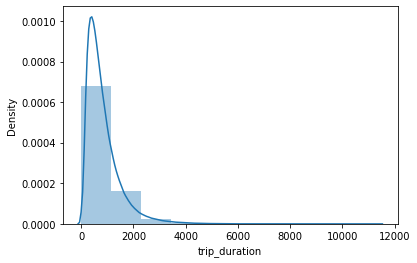

In [208]:
#Distribution plot of target variable
sns.distplot(nyc_df['trip_duration'],bins=10)

In [209]:
#prints skewness of target variable
print(nyc_df['trip_duration'].skew())

2.3189586838382477


The data is highly skewed to the right.

Lets perform a log transformation on target varibale to make it symmetrical and reduce the positive skewness.

In [210]:
#log transformed target variable
nyc_df['trip_duration']=np.log10(nyc_df['trip_duration'])

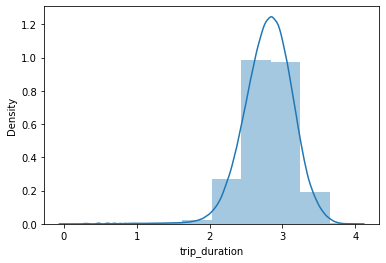

In [211]:
#Distribution plot of transformed target variable
sns.distplot(nyc_df['trip_duration'],bins=10)

The log transformed value has better symmetry as compared to the previous value of trip duration. 

In [212]:
#Skewness value after log transformation
nyc_df['trip_duration'].skew()

-0.6890991464496602

The target varibale is slightly left skewed after the log tranformation but it gives a better value. Lets go with it.

passenger_count:



In [213]:
#Count the number of unique values
nyc_df['passenger_count'].value_counts()

1    1032274
2     210008
5      77869
3      59777
6      48200
4      28348
0         59
7          3
9          1
8          1
Name: passenger_count, dtype: int64

The passenger_count of 0 is treated as error because the rides without passengers are not billable and passenger_counts with occurances 3,1 and 1 are treated as outliers which are the number of occurances of 7, 9 and 8 passenger counts respectively.

In [214]:
#Drop observations where the passenger count is 0 and greater than 6
nyc_df.drop(nyc_df[nyc_df['passenger_count'] >=7].index, inplace = True)     #Upper limit condition
nyc_df.drop(nyc_df[nyc_df['passenger_count'] ==0].index, inplace = True)     #Drops rows where passenger count is 0

In [215]:
#Count the number of unique values
nyc_df['passenger_count'].value_counts()

1    1032274
2     210008
5      77869
3      59777
6      48200
4      28348
Name: passenger_count, dtype: int64

We have geometrical points in terms of longitude and latitude of pickup and dropoff locations. 

Also the coordinates of New York city is as follow:

Latitude is between 40.7128 and 40.748817 

Longitude is between - 74.0059 and - 73.968285

In [216]:
#Minimum and miximum values of latitude and longitude
print('Latitide of pickup location lies between {0} and {1}'.format(nyc_df['pickup_latitude'].min(),nyc_df['pickup_latitude'].max()))
print('Longitude of pickup location lies between {0} and {1}'.format(nyc_df['pickup_longitude'].min(),nyc_df['pickup_longitude'].max()))
print('Latitide of dropoff location lies between {0} and {1}'.format(nyc_df['dropoff_latitude'].min(),nyc_df['dropoff_latitude'].max()))
print('Longitude of pickup location lies between {0} and {1}'.format(nyc_df['dropoff_longitude'].min(),nyc_df['dropoff_longitude'].max()))

Latitide of pickup location lies between 34.35969543457031 and 51.88108444213867
Longitude of pickup location lies between -121.93334197998048 and -61.33552932739258
Latitide of dropoff location lies between 32.1811408996582 and 43.92102813720703
Longitude of pickup location lies between -121.9333038330078 and -61.33552932739258


The pickup and dropoff longitudes and latitudes clearly do not lie in the New York region.

In [217]:
#Removing the ouliers among coordinates
nyc_df=nyc_df[nyc_df['pickup_latitude']>=40.7128]
nyc_df=nyc_df[nyc_df['pickup_latitude']<=40.748817]
nyc_df=nyc_df[nyc_df['dropoff_latitude']>=40.7128]
nyc_df=nyc_df[nyc_df['dropoff_latitude']<=40.748817]
nyc_df=nyc_df[nyc_df['pickup_longitude']>=-74.0059]
nyc_df=nyc_df[nyc_df['pickup_longitude']<=-73.968285]
nyc_df=nyc_df[nyc_df['dropoff_longitude']<=-73.968285]
nyc_df=nyc_df[nyc_df['dropoff_longitude']>=-74.0059]

#Shape of the data
nyc_df.shape      

(189681, 11)

**Feature Engineering**

Further, we can create features like speed and distance from the latitude and longitude values of pickup and drop location.

Distance:

In [218]:
#Function to return haversine ditance
def distance(lat1,long1,lat2,long2):
  '''Function to find sperical distance from one point to another
  lat- longitude
  long-longitude
  1-pickup location
  2-dropoff location
  '''
  distance = haversine((lat1,long1),(lat2,long1))+haversine((lat1,long1),(lat1,long2))    #Distance
  return distance

In [219]:
#distance column stores the values returned by distance function in KM 
nyc_df["distance"] = (nyc_df.apply(lambda row: distance(row.pickup_latitude, row.pickup_longitude,row.dropoff_latitude,row.dropoff_longitude), axis=1))

Distance is a function of pickup and dropoff longitude and latitude respectively. Further it can be used for calculation of speed.

Speed:

In [220]:
#Finding speed in KMPH from distance and trip_duration
nyc_df["speed"] = (nyc_df["distance"]) / ((10**nyc_df["trip_duration"])/3600)

In [221]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,2.821514,2.430509,13.197336
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,2.406540,1.774807,25.056097
17,id1154431,1,2016-04-14 08:48:26,2016-04-14 09:00:37,1,-73.994255,40.745804,-73.999657,40.723343,N,2.863917,2.952593,14.540812
19,id3390316,2,2016-06-05 13:47:23,2016-06-05 13:51:34,1,-73.983887,40.738197,-73.991203,40.727871,N,2.399674,1.764684,25.310206
37,id2403238,1,2016-06-23 23:00:09,2016-06-23 23:04:46,1,-73.988068,40.728081,-73.980751,40.721470,N,2.442480,1.351631,17.566318


In [222]:
# Delimit pickup_datetime variable 
nyc_df['pickup_datetime']=pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime']=pd.to_datetime(nyc_df['dropoff_datetime'])

nyc_df['pickup_date'] = nyc_df['pickup_datetime'].dt.date # Extract date
nyc_df['pickup_time'] = nyc_df['pickup_datetime'].dt.time # Extract time

# Delimit dropoff_datetime variables
nyc_df['dropoff_date'] = nyc_df['dropoff_datetime'].dt.date # Extract date
nyc_df['dropoff_time'] = nyc_df['dropoff_datetime'].dt.time # Extract time

# Additional pickup features
nyc_df['pickup_month'] = nyc_df['pickup_datetime'].dt.month # Extract month
nyc_df['pickup_hour'] = nyc_df['pickup_datetime'].dt.hour # Extract hour
nyc_df['pickup_weekday'] = nyc_df['pickup_datetime'].dt.dayofweek # Extract day
nyc_df['pickup_day']=nyc_df['pickup_datetime'].dt.day_name() #Extract day name

# Drop concatentated timestamp columns
nyc_df.drop(['pickup_datetime'], axis = 1, inplace = True)
nyc_df.drop(['dropoff_datetime'], axis = 1, inplace = True)

# Confirm columns
nyc_df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'distance', 'speed',
       'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time',
       'pickup_month', 'pickup_hour', 'pickup_weekday', 'pickup_day'],
      dtype='object')

In [223]:
#printing columns alongside data type
for col in nyc_df.columns:
  print(col, type(nyc_df.iloc[0][col]))

id <class 'str'>
vendor_id <class 'numpy.int64'>
passenger_count <class 'numpy.int64'>
pickup_longitude <class 'numpy.float64'>
pickup_latitude <class 'numpy.float64'>
dropoff_longitude <class 'numpy.float64'>
dropoff_latitude <class 'numpy.float64'>
store_and_fwd_flag <class 'str'>
trip_duration <class 'numpy.float64'>
distance <class 'numpy.float64'>
speed <class 'numpy.float64'>
pickup_date <class 'datetime.date'>
pickup_time <class 'datetime.time'>
dropoff_date <class 'datetime.date'>
dropoff_time <class 'datetime.time'>
pickup_month <class 'numpy.int64'>
pickup_hour <class 'numpy.int64'>
pickup_weekday <class 'numpy.int64'>
pickup_day <class 'str'>


## **Exploratory Data Analysis**

Analysisng the relationship between each feature variable.

In [224]:
# plt.figure(figsize=(10,5))
# plt.ylim(0,600)
# sns.pairplot(nyc_df)
# plt.show()

# **Univariate Analysis**

trip_duration:

Text(0, 0.5, 'Probability density')

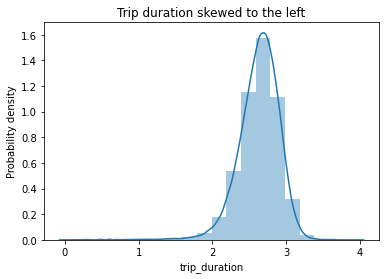

In [225]:
#Distribution plot of trip_duration
sns.distplot(nyc_df['trip_duration'],bins=20)
plt.title('Trip duration skewed to the left')     #title
plt.xlabel('trip_duration')                       #xlabel
plt.ylabel('Probability density')                 #ylabel

The target variable (trip_duration) is slightly skewed to the left.

passenger_count:

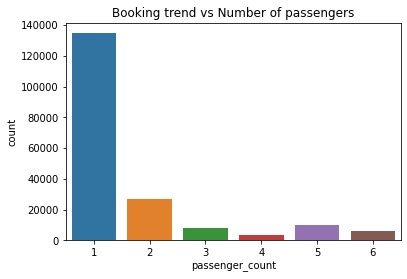

In [226]:
#Count plot of each passenger count
sns.countplot(x='passenger_count', data=nyc_df)
plt.title('Booking trend vs Number of passengers')
plt.show()

The most booked ride preferance of customers is booking for solo trips. The number of bookings for 4 number of passengers is least.

vendor_id:

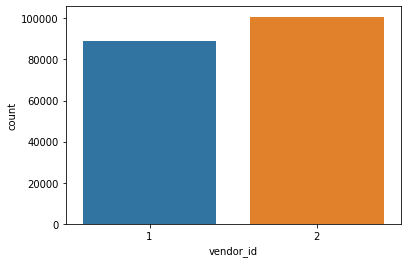

In [227]:
#Count plot w.r.t vendor ID
sns.countplot(x='vendor_id',data=nyc_df)

There is not much different on number of trips taken by both the vendors.

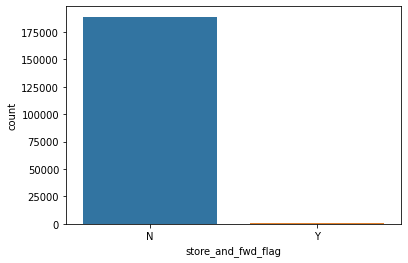

In [228]:
#Count plot of store_and_fwd_flag feature
sns.countplot(x='store_and_fwd_flag',data=nyc_df)

The number Y flags is negligible as comapred to the N flags. 

In [229]:
#Function to return percentage rounded upto 3 decimal digits
def dec_round(value):
  """
  User defined function to return percentage 
  rounded upto 3 decimal digits.
  """
  return round(value,3)

Y_per=len(nyc_df[nyc_df['store_and_fwd_flag']=='Y'])/len(nyc_df)          #Percentage of Y label
N_per=len(nyc_df[nyc_df['store_and_fwd_flag']=='N'])/len(nyc_df)          #Percentage of N label

#print statements
print('Percentage of Y flags in data:{}'.format(dec_round(Y_per)*100))
print('Percentage of N flags in data:{}'.format(dec_round(N_per)*100))

Percentage of Y flags in data:0.4
Percentage of N flags in data:99.6


The percentage of N flag is less than 1% of the entire observations in the dataset.

In [230]:
#count of unique distance covered
nyc_df['distance'].value_counts()

0.000000    1109
0.000424      14
0.000424       9
0.000848       6
0.000848       5
            ... 
1.171085       1
1.566245       1
3.377570       1
1.842215       1
1.665897       1
Name: distance, Length: 188525, dtype: int64

Distance equal to 0 can be considered as errors that can be present due to diffrent reasons related to the trip. We can drop the distances which can influence wrong predictions in data.

In [231]:
#Distances less than 0 are dropped
nyc_df=nyc_df[nyc_df['distance']>0]

sns.countplot(x="pickup_day",data=data,ax=ax1

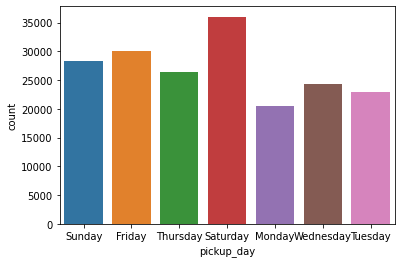

In [276]:
#Count plot of booking vs day
sns.countplot(x="pickup_day",data=nyc_df)

We see saturday is busiest followed by friday and mondays has least customer traffic.

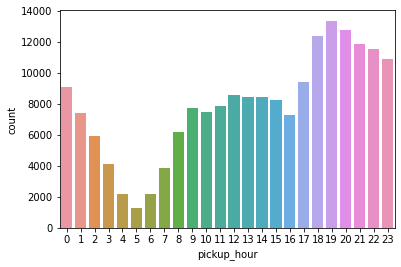

In [277]:
#Count plot of deiffrent pickup hours
sns.countplot(x="pickup_hour",data=nyc_df)

We see the busiest hours are between 7 PM and 8 PM with 5 AM as the least traffic hour.

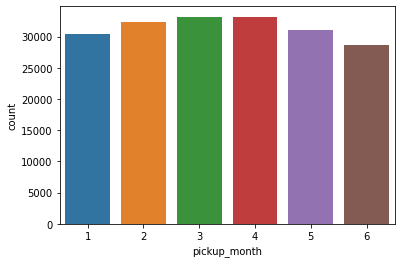

In [278]:
sns.countplot(x="pickup_month",data=nyc_df)

There is no diffrence between customer traffic on any given months but certainly month of june experienced reduction in customer bookings.

# **Multivariate Analysis**

longitudes, latitudes and pickup, dropoff :

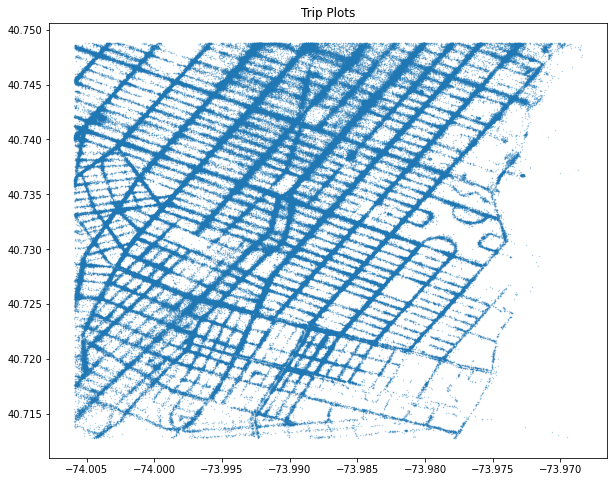

In [234]:
longitude = list(nyc_df.pickup_longitude) + list(nyc_df.dropoff_longitude)
latitude = list(nyc_df.pickup_latitude) + list(nyc_df.dropoff_latitude)
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
plt.title('Trip Plots')
plt.show()

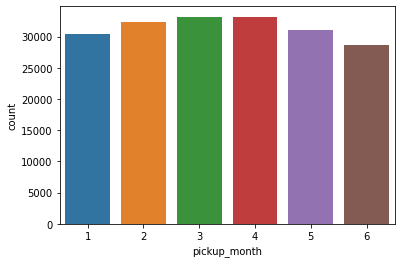

In [235]:
sns.countplot(x='pickup_month', data=nyc_df)

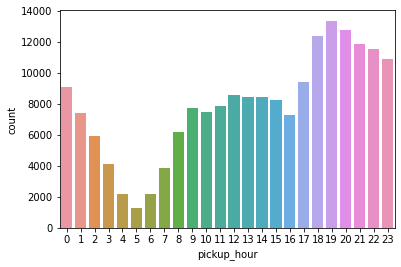

In [236]:
sns.countplot(x='pickup_hour', data=nyc_df)

# **Algorithm Development**

Let's plot numerical features and outline mean and median of each feature.

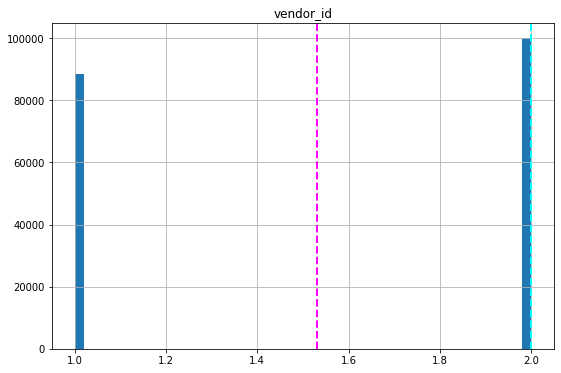

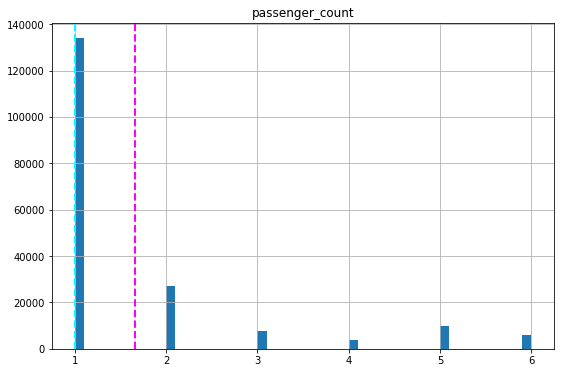

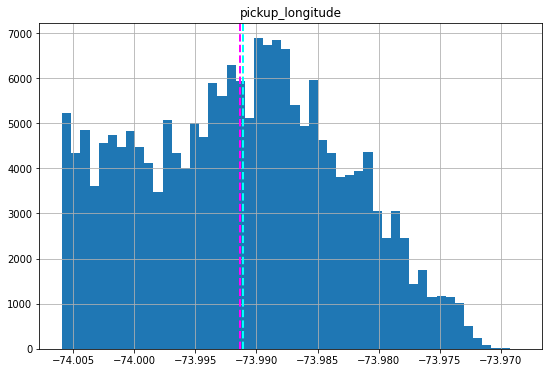

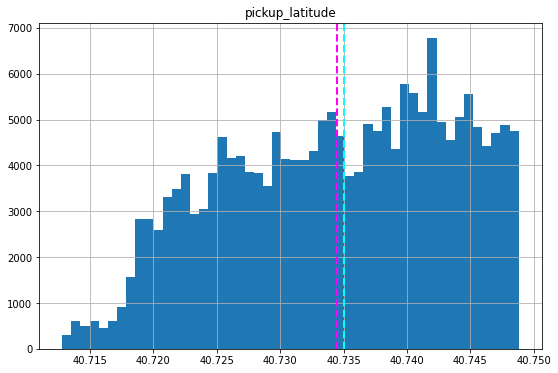

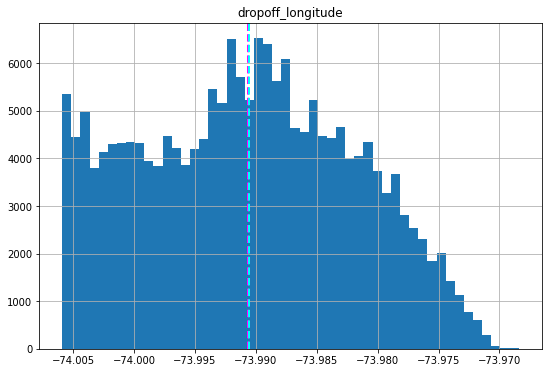

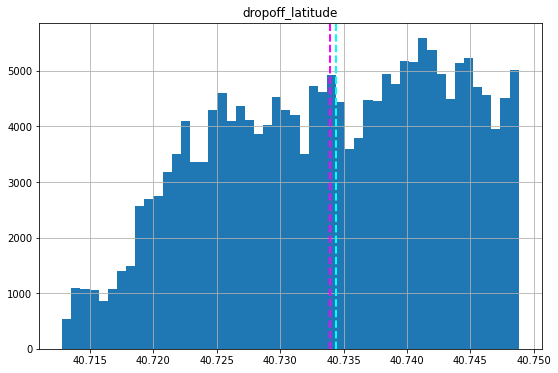

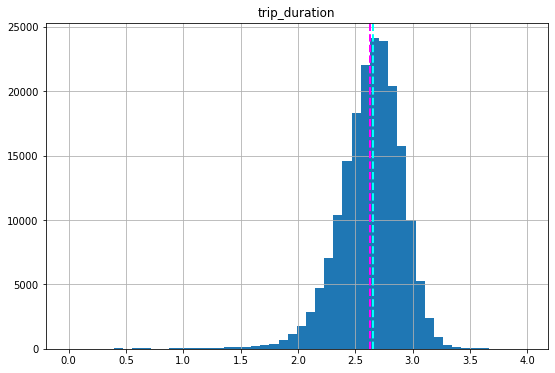

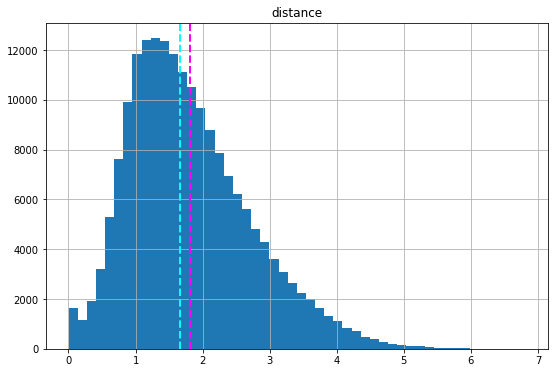

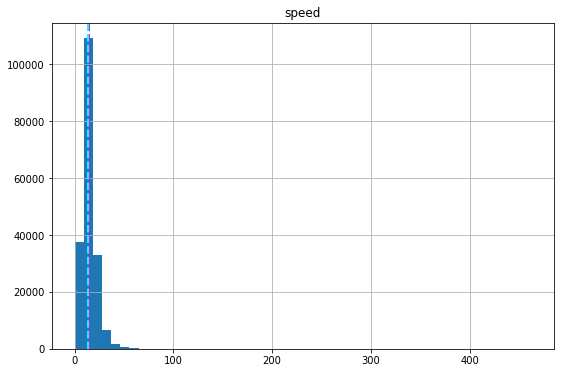

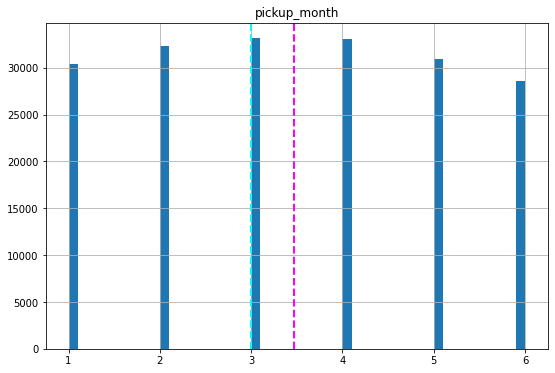

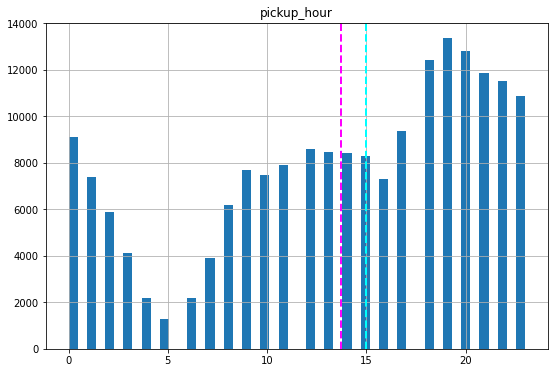

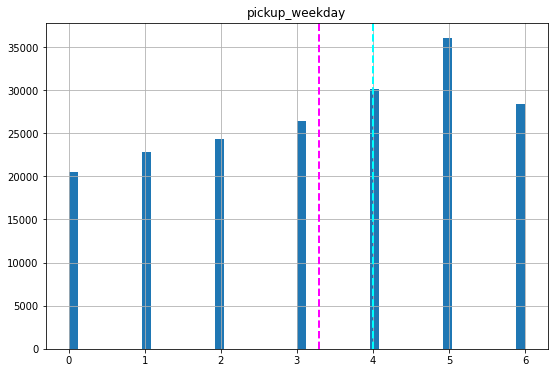

In [237]:
#Numerical features
numeric_features=nyc_df.describe().columns

#plotting numeric features with mean and median values
for col in numeric_features:
  fig=plt.figure(figsize=(9,6))
  ax=fig.gca()
  feature=nyc_df[col]
  feature.hist(bins=50, ax=ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(col)
plt.show()

The mean and median values are close for each numeric feature. Also some of the features are actually categorical and we may dismiss them from training dataset.

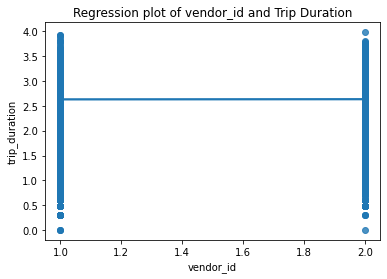

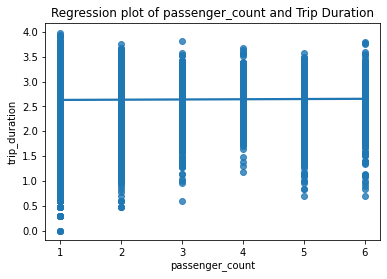

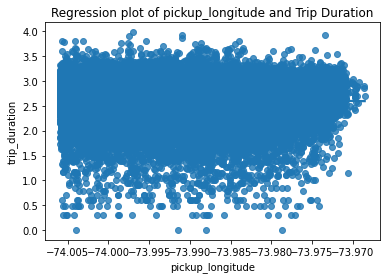

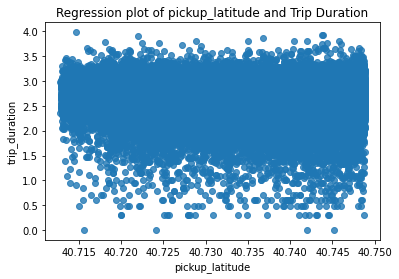

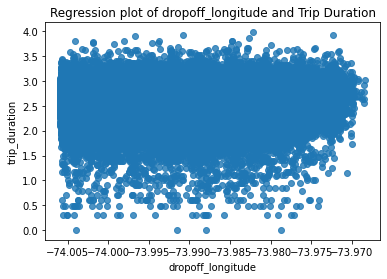

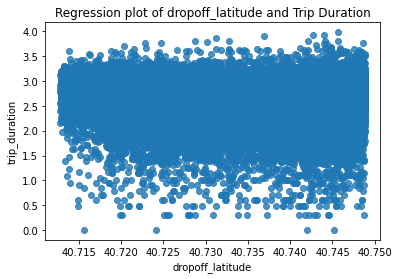

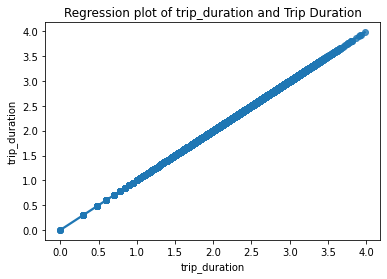

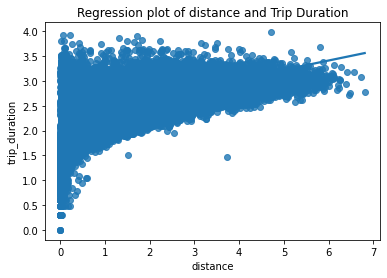

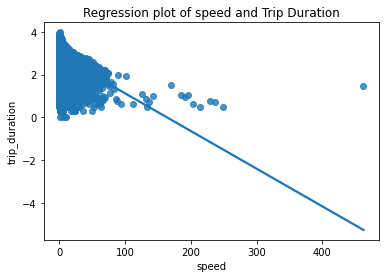

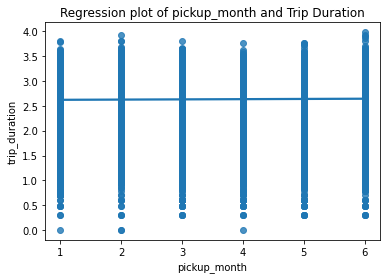

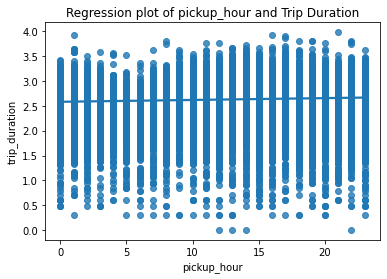

In [238]:
#fitting regression line on numeric features|
for var in numeric_features[0:-1]:
    plt.figure() # Creating a rectangle (figure) for each plot
    # Regression Plot also by default includes
    # best-fitting regression line
    # which can be turned off via `fit_reg=False`
    sns.regplot(x=var, y='trip_duration', data=nyc_df, ci=None).set(title=f'Regression plot of {var} and Trip Duration')

The regression line is not a fit for any of the variables except distance and speed. That means a linear relationship exists between speed, ditance and trip_duration.

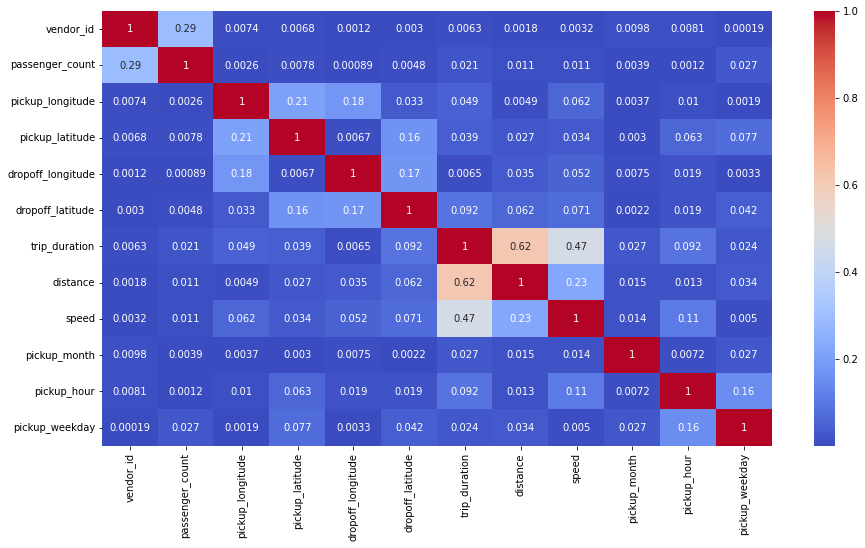

In [239]:
plt.figure(figsize=(15,8))
correlation = nyc_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

The relationship between speed and distance have somewhat correlation. Also the correlation between trip duration and distance is more than that of speed.

Lets look for the variance inflation factor.

In [240]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [241]:
calc_vif(nyc_df[[i for i in nyc_df.describe().columns if i not in ['trip_duration']]])

,variables,VIF
0,vendor_id,1.136824e+01
1,passenger_count,2.856007e+00
2,pickup_longitude,5.506287e+07
3,pickup_latitude,1.945786e+07
4,dropoff_longitude,5.479430e+07
5,dropoff_latitude,1.860330e+07
6,distance,5.269164e+00
7,speed,5.417082e+00
8,pickup_month,5.298754e+00
9,pickup_hour,5.155986e+00


In [242]:
calc_vif(nyc_df[[i for i in nyc_df.describe().columns if i not in ['trip_duration','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]])

,variables,VIF
0,vendor_id,8.364834
1,passenger_count,2.844048
2,distance,4.909814
3,speed,4.712877
4,pickup_month,4.466873
5,pickup_hour,4.121476
6,pickup_weekday,3.431851


In [243]:
calc_vif(nyc_df[[i for i in nyc_df.describe().columns if i not in ['trip_duration','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','vendor_id']]])

,variables,VIF
0,passenger_count,2.435546
1,distance,4.805313
2,speed,4.459556
3,pickup_month,4.194017
4,pickup_hour,3.728542
5,pickup_weekday,3.247932


In [244]:
numerical_features=['passenger_count','distance','speed','pickup_month','pickup_hour','pickup_weekday']

In [245]:
model_df=nyc_df

In [246]:
X=model_df[numerical_features]

In [247]:
y=model_df['trip_duration']

In [248]:
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(150857, 6)
(37715, 6)


## **Multivariate Linear Regression**

In [249]:
reg = LinearRegression().fit(X_train, y_train)

In [250]:
reg.score(X_train, y_train)

0.763510960609394

In [251]:
reg.coef_

array([ 0.00129031,  0.22939085, -0.02391449,  0.0011165 ,  0.00056646,
        0.00030172])

In [252]:
reg.intercept_

2.5530527429723175

In [253]:
y_pred = reg.predict(X_test)

In [254]:
from sklearn import metrics
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(10**y_test,10**y_pred))
print('MAE:',metrics.mean_absolute_error(10**y_test,10**y_pred))
print('MSE:',metrics.mean_squared_error(10**y_test,10**y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(10**y_test,10**y_pred)))


Linear Regression Performance Metrics
R^2= 0.6277885208311058
MAE: 84.1202901974071
MSE: 35273.159597049795
RMSE: 187.81150017251286


In [255]:
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Adjusted R2 :  0.6257142969495452


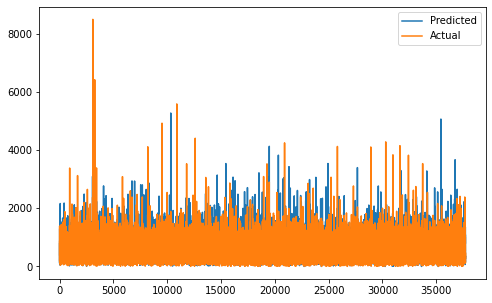

In [256]:
plt.figure(figsize=(8,5))
plt.plot(10**y_pred)
plt.plot(10**(np.array(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()

## **Ridge Regression**

In [257]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [258]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 30}

Using  {'alpha': 30}  the negative mean squared error is:  -0.018089966279240005


In [259]:
y_pred_ridge = ridge_regressor.predict(X_test)

In [260]:
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(10**y_test,10**y_pred_ridge))
print('MAE:',metrics.mean_absolute_error(10**y_test,10**y_pred_ridge))
print('MSE:',metrics.mean_squared_error(10**y_test,10**y_pred_ridge))
print('RMSE:',np.sqrt(metrics.mean_squared_error(10**y_test,10**y_pred_ridge)))


Linear Regression Performance Metrics
R^2= 0.6280212921842354
MAE: 84.10008083018764
MSE: 35252.072823429495
RMSE: 187.75535364785074


In [261]:
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Adjusted R2 :  0.6259380500235454


## **Lasso Regression**

In [262]:
from sklearn.linear_model import Lasso
lasso  = Lasso(alpha=0.0001 , max_iter= 3000)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, max_iter=3000)

In [263]:
lasso.score(X_train, y_train)

0.7635106287754374

In [264]:
lasso.coef_

array([ 0.00123404,  0.22926405, -0.02390952,  0.00108085,  0.00056397,
        0.00027621])

In [265]:
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             scoring='neg_mean_squared_error')

In [266]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  -0.01806845928294188


In [267]:
y_pred_lasso = lasso_regressor.predict(X_test)

In [268]:
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(10**y_test,10**y_pred_lasso))
print('MAE:',metrics.mean_absolute_error(10**y_test,10**y_pred_lasso))
print('MSE:',metrics.mean_squared_error(10**y_test,10**y_pred_lasso))
print('RMSE:',np.sqrt(metrics.mean_squared_error(10**y_test,10**y_pred_lasso)))


Linear Regression Performance Metrics
R^2= 0.6278391440653134
MAE: 84.11561559947701
MSE: 35268.58862124137
RMSE: 187.7993307262871


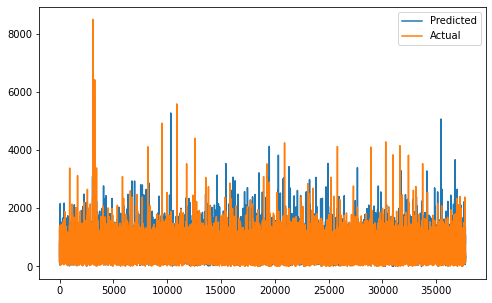

In [269]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred_lasso))
plt.plot(10**(np.array(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()

## **Elastic Net**

In [270]:
from sklearn.linear_model import ElasticNet
#a * L1 + b * L2
#alpha = a + b and l1_ratio = a / (a + b)
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

In [271]:
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1)

In [272]:
elasticnet.score(X_train, y_train)

0.7044767285971103

In [273]:
y_pred_en = elasticnet.predict(X_test)

In [274]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_en))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_en))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_en)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 31859.798270104133
RMSE : 178.4931322771387
R2 : 0.6619874712022141
Adjusted R2 :  0.6619336875177761


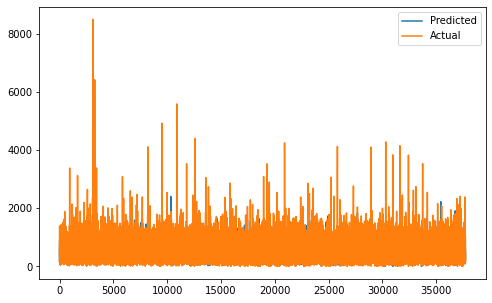

In [275]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred_en))
plt.plot(10**(np.array(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()